In this notebook we study the effect of gamma
on natural and robust accuracy.

### Set up libraries

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
from typing import Dict, Tuple
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import thundersvm

import jax
import jax.numpy as jnp
from jax.interpreters import xla
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

import neural_tangents as nt
from neural_tangents import stax

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [3]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset, attacks, jthunder, kernel

### Load Data

In [4]:
%%time

MNIST_TRAIN = dataset.get_np_data(
    name="mnist", split="train", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))
MNIST_TEST = dataset.get_np_data(
    name="mnist", split="test", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))

CIFAR_TRAIN = dataset.get_np_data(
    name="cifar10", split="train", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))
CIFAR_TEST = dataset.get_np_data(
    name="cifar10", split="test", agg_labels=((0,1,2,3,4), (5,6,7,8,9)))

print(MNIST_TRAIN.xs.shape)
print(MNIST_TEST.xs.shape)
print(CIFAR_TRAIN.xs.shape)
print(CIFAR_TEST.xs.shape)

(60000, 784)
(10000, 784)
(50000, 3072)
(10000, 3072)
CPU times: user 22.6 s, sys: 20.2 s, total: 42.8 s
Wall time: 7.98 s


[0 0 0 1 1 0 0 1 0 1]


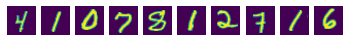

[0 0 0 1 1 1 0 1 0 0]


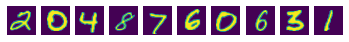

[1 1 0 0 1 1 0 1 1 1]


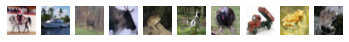

[1 0 1 1 1 0 1 0 0 0]


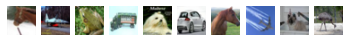

In [5]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)
dataset.plot_images(CIFAR_TRAIN, channels=3)
dataset.plot_images(CIFAR_TEST, channels=3)

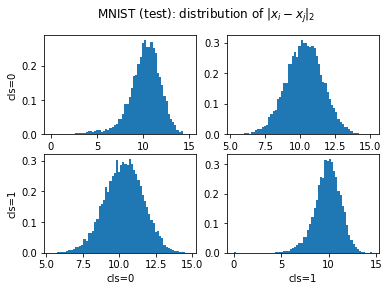

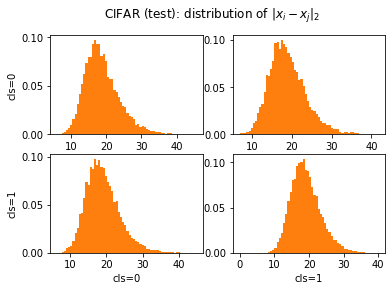

In [6]:
def plot_avg_dists(ds: dataset.Dataset, num_samples=1000, **plt_kwargs):
    dists = np.zeros((2, 2, num_samples))
    for i in range(2):
        for j in range(2):
            xs_i = ds.xs[ds.ys == i]
            xs_j = ds.xs[ds.ys == j]
            
            idxs_i = np.random.randint(0, xs_i.shape[0], size=num_samples)
            idxs_j = np.random.randint(0, xs_j.shape[0], size=num_samples)
            
            diffs = xs_i[idxs_i] - xs_j[idxs_j]
            dists[i, j] = np.linalg.norm(diffs, ord=2, axis=-1)
    
    for i in range(2):
        for j in range(2):
            plt.subplot(2, 2, 1 + 2 * i + j)
            plt.hist(dists[i, j], **plt_kwargs)
            if j == 0:
                plt.ylabel(f"cls={i}")
            if i == 1:
                plt.xlabel(f"cls={j}")

plt.suptitle("MNIST (test): distribution of $\|x_i - x_j\|_2$")
plot_avg_dists(MNIST_TEST, num_samples=10**4, bins=64, density=True)
plt.show();

plt.suptitle("CIFAR (test): distribution of $\|x_i - x_j\|_2$")
plot_avg_dists(CIFAR_TEST, num_samples=10**4, bins=64, density=True, color="tab:orange")
plt.show();

### Utility code

In [7]:
def ds_prefix(ds: dataset.Dataset, sz: int) -> dataset.Dataset:
    return dataset.Dataset(name=f"{ds.name}[:{sz}]", xs=ds.xs[:sz], ys=ds.ys[:sz])

def avg_by_cls(xs, ys) -> Tuple[float, float]:
    return (xs[ys == 0].mean(), xs[ys == 1].mean())

def accs_by_cls(clf: thundersvm.SVC, ds: dataset.Dataset) -> Tuple[float, float]:
    return avg_by_cls(clf.predict(ds.xs) == ds.ys, ds.ys)

def fmt_accs(accs: Tuple) -> str:
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

def print_dict(d: Dict):
    def fmt(v):
            if isinstance(v, tuple):
                return fmt_accs(v)
            elif isinstance(v, float):
                return f"{v:.2e}"
            return v
            
    print({
        k : fmt(v) for
        k, v in d.items()
        if not isinstance(v, np.ndarray)
    })

In [8]:
def eval_ds(
    clf: thundersvm.SVC,
    ds: dataset.Dataset,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    batch_size: int
) -> Dict:
    res_dict = dict(
        ds_name=ds.name,
        xs=ds.xs,
        ys=ds.ys,
    )
    
    res_dict["accs"] = accs_by_cls(clf=clf, ds=ds)
    
    clf_grad_fn = jthunder.get_grad_decision_function(clf)
    
    xs_pgd = attacks.pgd(
        X=ds.xs, Y=ds.ys,
        grad_func=clf_grad_fn,
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=True,
        batch_size=batch_size,
    )
    res_dict["xs_pgd"] = xs_pgd
    
    res_dict["accs_pgd"] = accs_by_cls(clf=clf, ds=dataset.Dataset(xs=xs_pgd, ys=ds.ys))

    sfmargs = res_dict["sfmargs"] = jthunder.decision_function(clf, ds.xs).to_py() * (2 * ds.ys - 1)
    grad_norms = res_dict["grad_norms"] = np.linalg.norm(
        clf_grad_fn(ds.xs),
        axis=-1, ord=2
    )
    
    res_dict["accs_linadv"] = avg_by_cls(grad_norms * attack_eps <= sfmargs, ds.ys)
    
    return res_dict

In [9]:
def eval_clf(
    clf: thundersvm.SVC,
    datasets: dataset.Dataset,
    base_dict: Dict,
    verbose: bool,
    **kwargs,
) -> Dict:
    res_dict: dict = base_dict.copy()
    res_dict.update(dict(
        n_support=list(clf.n_support_),
        b=clf.intercept_[0],
        gam=clf._gamma,
        coef0=clf.coef0,
        **kwargs
    ))
    if verbose: print_dict(res_dict)
    
    res_dict["norm"] = np.sqrt(jthunder.norm2(clf))
    if verbose: print(f"norm={res_dict['norm']}")
    
    res_dict["ds_results"] = []
    for ds in datasets:
        ds_res_dict = eval_ds(clf, ds, **kwargs)
        res_dict["ds_results"].append(ds_res_dict)
        
        if verbose: print_dict(ds_res_dict)
    
    return res_dict

# Begin experiments

In [10]:
RESULTS = {}

## RBF kernel

In [11]:
%%time
CUR_KEY = "svm-rbf"
RESULTS[CUR_KEY] = []
print(f"Running {CUR_KEY}...")

for gamma in [1e-3, 1e-2, 1e-1, 1]:
    for c in [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]:
        clf = thundersvm.SVC(kernel="rbf", C=c, gamma=gamma)
        clf.fit(MNIST_TRAIN.xs, MNIST_TRAIN.ys)

        RESULTS[CUR_KEY].append(eval_clf(
            clf=clf,
            base_dict=dict(c=c, gamma=gamma),
            datasets=[ds_prefix(MNIST_TRAIN, 512), ds_prefix(MNIST_TEST, 512)],
            verbose=True,
            attack_eps=1.0,
            pgd_step_size=1.0/10,
            pgd_num_steps=20,
            batch_size=512,
        ))

Running svm-rbf...
{'c': '1.00e-03', 'gamma': '1.00e-03', 'n_support': [29404, 29404], 'b': '8.02e-01', 'gam': '1.00e-03', 'coef0': '0.00e+00', 'attack_eps': '1.00e+00', 'pgd_step_size': '1.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=2.2176547466292615
{'ds_name': 'mnist-train[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'c': '1.00e-02', 'gamma': '1.00e-03', 'n_support': [24746, 24747], 'b': '-4.31e-01', 'gam': '1.00e-03', 'coef0': '0.00e+00', 'attack_eps': '1.00e+00', 'pgd_step_size': '1.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=12.417206403336968
{'ds_name': 'mnist-train[:512]', 'accs': '(0.7673, 0.8240)', 'accs_pgd': '(0.5755, 0.5543)', 'accs_linadv': '(0.5551, 0.5019)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.7886, 0.8308)', 'accs_pgd': '(0.6382, 0.5714)', 'accs_linadv': '(

### Visualize adv. examples found via pgd
These are clipped to to have pixel values in $[0, 1]$.

Natural
[0 0 0 1 1 1 0 1 0 0]


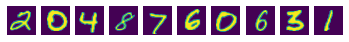


Adversarial
[0 0 0 1 1 1 0 1 0 0]


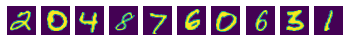

In [12]:
print("Natural")
dataset.plot_images(MNIST_TEST, channels=1)
print()
print("Adversarial")
dataset.plot_images(
    dataset.Dataset(xs=RESULTS["svm-rbf"][-1]["ds_results"][1]["xs_pgd"], ys=MNIST_TEST.ys),
    channels=1
)

### nat-err vs. adv-err as $C$ is varied

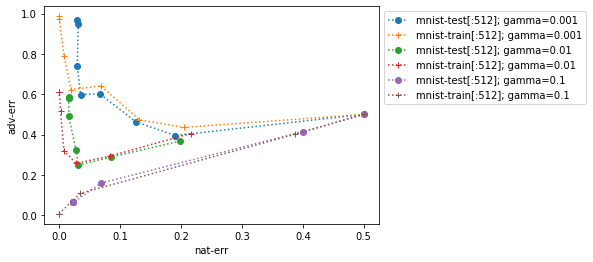

In [20]:
def main_plot():
    num_ds = len(RESULTS["svm-rbf"][0]["ds_results"])
    gammas = set(d["gamma"] for d in RESULTS["svm-rbf"])
    
    for gamma in [1e-3, 1e-2, 1e-1]:
        for ds_idx, fmt in zip([1, 0], ["o:", "+:"]):
            ds_name = RESULTS["svm-rbf"][0]["ds_results"][ds_idx]["ds_name"]

            accs = []
            accs_pgd = []
            for res_dict in (rd for rd in RESULTS["svm-rbf"] if rd["gamma"] == gamma):
                ds_dict = res_dict["ds_results"][ds_idx]
                accs.append(sum(ds_dict[f"accs"]) / 2.0)
                accs_pgd.append(sum(ds_dict[f"accs_pgd"]) / 2.0)

            accs = np.array(accs)
            accs_pgd = np.array(accs_pgd)

            plt.plot(1 - accs, 1 - accs_pgd, fmt, label=f"{ds_name}; gamma={gamma}")
    
    plt.xlabel("nat-err");
    plt.ylabel("adv-err");
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);
    
#plt.figure(figsize=(12, 4))
    
#plt.subplot(1, 2, 1)
main_plot()

#plt.subplot(1, 2, 2)
#main_plot()
#plt.xlim(0, 0.25);
#plt.ylim(0.8, 1.01);